In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np

import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

import stylised_facts_data_utilities.createLOB as createLOB

%matplotlib inline
import os
import scipy
from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
import pyinform as pyinf
import pingouin as pig
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div

In [3]:
ss

In [4]:
dataFolder = '/media/ak/WorkDrive/Data'
figures_destination = '/home/ak/Documents/Research/Papers/figures/'

In [5]:
quotes =[f for f in os.listdir(dataFolder) if str('_quotes') in f]
trades =[f for f in os.listdir(dataFolder) if str('_trades') in f]

In [6]:
symbols = ['VIX',  'FB1',  'TU1',  'G_1',  'RX1',  'OE1',  'TY1',  'FV1',
 'JB1',  'RX1',  'DU1',  'KE1',  'US1',  'YM1', 'XM1',  'VXX'] 

In [7]:
def quantile_plot(x, **kwargs):
    quantiles , xr = stats.probplot(x, fit= True)
    plt.scatter(xr, quantiles, **kwargs)
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))
import statsmodels.api as sm

def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(20,14))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
        
    file_name = 'multiclocks_autocorrel.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout() 

In [8]:
class volatilityEstimation(object):
    
    def __init__(self, df, tick_window=20, clean=True):
        self.df = df
        self.tick_window = tick_window
        self.mu_1 =  np.sqrt((2 / np.pi))
        self.mu_43 = 2**(2 / 3) * scipy.special.gamma(7 / 6) ** scipy.special.gamma(1 / 2) ** (-1)
        self.clean = True #set to true to remove nans at the beginning of the period
        self.trading_seconds_btc = 86400
        self.trading_seconds_futures = 23400
                      
        self.column_open ='micro_price_open'
        self.column_high = 'micro_price_high'
        self.column_low = 'micro_price_low'
        self.column_close = 'micro_price_close'

        self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
        self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        # median sampling frequency
        
        self.z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        self.clean_arrival_rates = np.asarray(self.z[(self.z>self.z.quantile(0.003)) & ( self.z < self.z.quantile(0.97) ) ].dropna()).astype('float64')
        # clean arrival rates after i remove all the outliers
        self.mean_sampling_frequency = np.mean(np.asarray(self.clean_arrival_rates))
        
 
    def arrival_rates(self):
        
        z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        clean_arrival_rates = np.asarray(z[(z>z.quantile(0.003)) & (z<z.quantile(0.97)) ].dropna()).astype('float64')
                                         # clean arrival rates after i remove all the outliers
        
        return clean_arrival_rates
        
    
    def M_parameter(self):
        """
        normalised sampling frequency for adjustments
        """
       
        M_btc = self.trading_seconds_btc / self.mean_sampling_frequency
        M_futures = self.trading_seconds_futures / self.mean_sampling_frequency        
        
        return [M_btc, M_futures]
        
    
    def garmanKlass(self, trading_periods):
        
        rs = 0.5 * self.log_hl ** 2 - (2 * np.log(2) - 1) * self.log_co ** 2

        def f(v):
            return (trading_periods * v.mean()) ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if  self.clean:
            return result.dropna()
        else:
            return result
    
    def parkinson(self, trading_periods, clean = True):

        rs = (1.0 / (4.0 * np.log(2.0))) *(self.df[str(self.column_high)] / self.df[str(self.column_close)]).apply(np.log) ** 2.0

        def f(v):
            return trading_periods * v.mean() ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if self.clean:
            return result.dropna()
        else:
            return result
    
    def bipower_variation(self, rollingWindow=5):
        '''
        Bipower Variation (BV) is the sum of the product of absolute time series returns
        :param column: price column
        :return: returns bivariate variation
        Barnhorf - Nielse & Shephard 2004 & 2006
        '''
        bv = self.mu_1 ** (-2) * ((self.log_hl.abs() *self.log_hl.shift(1).abs()).fillna(0).rolling(rollingWindow).sum())
        
        if self.clean:
            return bv.dropna()
        else:
            return bv

    
    def tripower_quarticity(self, rollingWindow=5, sampling_param = 0):
        """
        using M for BTC here - change sampling param to 1 for everything else
        """
        tpq = self.M_parameter()[sampling_param] * self.mu_43 ** (-3) * (( self.log_hl.abs()**(4 /3) * self.log_hl.shift(1).abs() **(4 / 3) * self.log_hl.shift(2).abs() **(4 / 3) ).rolling(rollingWindow).sum().fillna(0))
        
        if self.clean:
            
            return tpq.dropna()
        else:
            return tpq

    
    def realised_variance(self, rollingWindow=5):
        """
        realised variance - andersen & bollerselv -1998
        """

        realvar = (self.log_hl **2).rolling(rollingWindow).sum().fillna(0)
        
        if self.clean:
            return realvar.dropna()
        else:
            return realvar
    
    def realised_absolute_variation(self, rollingWindow=5, sampling_param = 0):
        """
        realised absolute variation - Forsberg & Ghysels 2007
        using M for BTC here - change sampling param to 1 for everything else
        """
        
        realabsovar = self.mu_1 **(-2) *self.M_parameter[sampling_param] **(-0.5) * self.log_hl.rolling(rollingWindow).sum().fillna(0)
        
        return realabsovar
    
    def realised_skewness_kurtosis(self, rollingWindow = 15, sampling_param = 0):
        
        """
        set the rolling window to 10-15
        sampling param for BTC ~ 0
        """
        
        rm3 = (self.log_hl **3).rolling(rollingWindow).sum().fillna(0)
        rm4 = (self.log_hl **4).rolling(rollingWindow).sum().fillna(0)
        
        rs = np.sqrt(self.M_parameter()[sampling_param]) * (rm3 / self.realised_variance(rollingWindow = rollingWindow)) **(3/2)
        rk = self.M_parameter()[sampling_param] * (rm4 / self.realised_variance(rollingWindow = rollingWindow)) ** 2
        
        return rs, rk
    
    def jumps_test(self, rollingWindow, sampling_param = 0):
        """
        Jump test by Huang and Tauchen 2005
        adopted by repo: RealisedQuantities
        """
        
        j1 = (np.log(self.realised_variance(rollingWindow= rollingWindow)) - np.log(self.bipower_variation(rollingWindow = rollingWindow))) 
        j2 = (((self.mu_1 **-4) +2* (self.mu_1 **-2) -5 ) / 
              (self.M_parameter()[0]*self.tripower_quarticity(rollingWindow = rollingWindow, sampling_param=sampling_param)
                *(self.bipower_variation(rollingWindow = rollingWindow)**-2)))
        
        j = j1 / (j2 ** 0.5)          
        
        
        return (j.abs() >= stats.norm.ppf(0.995))*1 # can also look at 0.999)*
    
    def relative_jump_measure(self, rollingWindow, sampling_param = 0):

        nominator = (self.realised_variance(rollingWindow= rollingWindow) 
                     - self.bipower_variation(rollingWindow = rollingWindow))
        
        measure_to_return = nominator / self.bipower_variation(rollingWindow = rollingWindow)
        
        return measure_to_return

        
    

    def negative_semivariance(self, x):
        """
        input: returns
        negative realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x<0).sum()

    def positive_semivariance(self, x):
        """
        input: returns
        positive realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x>0).sum()
    
    def signed_jump_variation(self, x):
        
        sjv = self.positive_semivariance(x) -self.negative_semivariance(x)
        sjv_p = sjv*(sjv>0)
        sjv_n = sjv*(sjv<0)
        
        return sjv_p, sjv_n
    
    def continuous_discontinuous_quadratic_variance(self):
        
        """
        seperate continuous and discontinuous parts of quadratic variation
        
        """
        pass                                                                                                                                 




class descriptiveStats(object):
       
        def __init__(self, df):
        
            self.df = df
            self.column_open ='micro_price_open'
            self.column_high = 'micro_price_high'
            self.column_low = 'micro_price_low'
            self.column_close = 'micro_price_close'
            self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
            self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        
        def base_descriptive_stats(self):

            desc_stats =dict()
            desc_stats['median_hl'] = np.median(self.log_hl)
            desc_stats['mean_co'] = np.median(self.log_co)
            desc_stats['quantile_95_hl'] = self.log_hl.quantile(0.95)
            desc_stats['quantile_95_co'] = self.log_co.quantile(0.95)
            desc_stats['q3_75_hl'] = self.log_hl.quantile(0.75)
            desc_stats['q3_75_co'] = self.log_co.quantile(0.75)
            desc_stats['q1_25_hl'] = self.log_hl.quantile(0.25)
            desc_stats['q1_25_co'] = self.log_co.quantile(0.25)
            desc_stats['outlier_lower_limit_hl'] = desc_stats['q1_25_hl'] - 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['outlier_upper_limit_hl'] = desc_stats['q3_75_hl'] + 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['lower_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_lower_limit_hl']].count()
            desc_stats['upper_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_upper_limit_hl']].count()
            desc_stats['total_outliers'] = desc_stats['lower_limit_outliers'] + desc_stats['upper_limit_outliers']
            
            return desc_stats

        
        


In [9]:

class DataLoader:
    """
    loads data and constructs full LOB and calendar bars for each one
    """
    def __init__(self, data_location, 
                 symbol,
                 dates, 
                 use_columns, 
                 calendar_resample,
                 trade_volume_width, 
                 ticks_width, 
                 usd_volume_width):
        
        self._data_location = data_location
        self._symbol= symbol
        self._input_dates = dates
        self._use_columns = use_columns
        self._calendar_resample = calendar_resample
        self._ticks_width = ticks_width
        self._trade_volume_width = trade_volume_width
        self._usd_volume_width = usd_volume_width
        self._dates = []
        self._bars_dict = {}
        self.calendar_bars = []
        self.volume_bars = []
        self.tick_bars = []
        self.usd_volume_bars = []
        self._logger = logger('DataLoader')
#         self._symbols = sorted(['VIX',  'FB1',  'TU1',  'G_1',  'RX1',  'OE1',  'TY1',  'FV1',  'JB1',  'RX1',  'DU1',  'KE1',  'US1',  'YM1', 'XM1',  'VXX'] )
        self._data_folder = data_location
        
        self._quotes_string = "".join((self._symbol, '_Comdty_quotes' ))
        self._trades_string = "".join((self._symbol, '_Comdty_trades' ))
        
#         self._quotes_files =sorted([ f for f in os.listdir(self._data_folder) if str('_quotes') in f])
#         self._trades_files = sorted([f for f in os.listdir(self._data_folder) if str('_trades') in f])
        
        self._quotes_Files = os.path.join(self._data_folder, self._quotes_string)
        self._trades_Files = os.path.join(self._data_folder, self._trades_string)
    
    def load_and_format_data(self):
        mergedFile = dict()
        for date in self._input_dates:
            dateToLoad = os.path.join(date + '.csv')
            self._logger.info(f"Loading data for:{date}")
            
            quotesDateFile = os.path.join(self._quotes_Files, dateToLoad)
            print(quotesDateFile)
            tradesDateFile = os.path.join(self._trades_Files, dateToLoad)
            print(tradesDateFile)
            
            try:
                qt_tmp_df = pd.read_csv(quotesDateFile, usecols=self._use_columns)
                qt_tmp_df['TradeTime'] = pd.to_datetime(qt_tmp_df.time).values
                              
                quotes_df =pd.merge_asof(qt_tmp_df[qt_tmp_df['type'] =='BID'].dropna().fillna("ffill").sort_values('TradeTime')
                                         , qt_tmp_df[qt_tmp_df['type'] =='ASK'].dropna().fillna("ffill").sort_values('TradeTime'), 
                                         on='TradeTime', allow_exact_matches=True)
                
                quotes_df = quotes_df.rename( columns={'value_x': 'BestBid', 'value_y': 'BestAsk',
                 'size_x': 'BidSize', 'size_y': 'AskSize', 'time_x': 'QuoteTime' })
                              
                tr_tmp_df = pd.read_csv(tradesDateFile, usecols=self._use_columns)
                tr_tmp_df['TradeTime'] = pd.to_datetime(tr_tmp_df.time).values
                trades_df= tr_tmp_df.dropna().fillna("ffill").sort_values('TradeTime')
                trades_df = trades_df.rename( columns={'value': 'TradePrice', 
                                                       'size': 'TradeSize'})
                trades_columns = ['TradeSize', 'type','TradePrice','TradeTime']
                
                LOB =pd.merge_asof(quotes_df, trades_df[trades_columns].sort_values('TradeTime'), on='TradeTime', allow_exact_matches=True)
                
                LOB.BidSize = LOB['BidSize'].replace(0, 1)
                LOB.AskSize = LOB['AskSize'].replace(0, 1)
                LOB['TimeStamp'] = pd.to_datetime(LOB.TradeTime).dt.time
                LOB['TradeVolume'] = LOB['TradeSize'].fillna(0)
                LOB['total_traded_volume'] = LOB.TradeVolume
                LOB['milliSeconds'] = [(((x.hour * 60 + x.minute) * 60 + x.second) * 1000) for x in LOB['TimeStamp']]
                LOB['dollar_traded_volume'] = pd.Series(LOB.TradePrice * LOB.TradeVolume).fillna(0)
                LOB['timeStampIdx'] = pd.DatetimeIndex(LOB.time_y)
                LOB['micro_price'] = (LOB.BestAsk * LOB.AskSize + LOB.BestBid * LOB.BidSize) / (LOB.AskSize + LOB.BidSize)  #
                
                mergedFile[date] = LOB
                
            except FileNotFoundError:
                self._logger.info(f"Data for day {date} does not exist. Skipping this day")
        return mergedFile
    
    def apply_micro_structure_features(self, df):
        
        self._logger.info("Applying micro-structure features")
        
     
        df['weighted_average_bid_price'] = pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
        pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1) / pd.DataFrame(df.filter(like='bid_size', axis=1).values).sum(axis=1)
        
        df['weighted_average_ask_price'] = pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(
            axis=1) / pd.DataFrame(df.filter(like='ask_size', axis=1).values).sum(axis=1)
        df['weighted_activity_spread'] = df['weighted_average_ask_price'] - df['weighted_average_bid_price']
        df['total_size'] = (pd.DataFrame(df.filter(like='ask_size', axis=1).values).sum(axis=1) +
                            pd.DataFrame(df.filter(like='bid_size', axis=1).values).sum(axis=1))
        df['micro_price'] = ((pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1) +
                              pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
                                  pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(axis=1))) / df['total_size']
        df['price_imbalance'] = ((pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(axis=1) -
                                  pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
                                      pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1))) / df[
                                    'total_size']
        df['pct_change_micro_price'] = df.micro_price_close.pct_change()
        df['simple_mid_price'] = 0.5 * (pd.DataFrame(df.filter(like='ask_price', axis=1)).mean(axis=1) +
                                        pd.DataFrame(df.filter(like='bid_price', axis=1)).mean(axis=1))

        # TODO: do we want to be using pct_change here or log returns?
        return df

    @staticmethod
    def prep_bars(df, drop_col):
        df.columns = [f"{i[0]}_{j}" for i, j in zip(df.columns, ['open', 'high', 'low', 'close'] * len(df.columns))]
        if drop_col:
            df.drop([f"{drop_col}_{i}" for i in ['open', 'high', 'low', 'close']], axis=1, inplace=True)
        return df

    
    def drop_lob_columns(df):
        #not using this anywhere at the moment
        
        ask_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_price_', axis=1)).columns.values)
        ask_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_size_', axis=1)).columns.values)
        bid_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_size_', axis=1)).columns.values)
        bid_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_price_', axis=1)).columns.values)
        time_stamps = ['timestamp', 'timestamp.1', 'exchange_time', 'feed_time']
        columns_to_be_dropped = ask_price_columns_to_be_dropped + ask_size_columns_to_be_dropped + \
                                bid_size_columns_to_be_dropped + bid_price_columns_to_be_dropped + \
                                time_stamps
        df = df.drop(columns=columns_to_be_dropped)

        return df
    
    def get_bars(self, df):
        
        self._logger.info('Calculating calendar clock')
        calendar_bars = df.resample(rule=self._calendar_resample, on='timeStampIdx').agg(['first', 'max', 'min', 'last'])
        calendar_bars = self.prep_bars(calendar_bars, 'timeStampIdx')

        self._logger.info('Calculating volume clock')
        # TODO: Doing this on day-by-day basis. We lose the last turn of the clock each day
        df['cum_total_trade_volume'] = df.total_traded_volume.cumsum()
        df['volume_bucket'] = np.floor(df.cum_total_trade_volume / self._trade_volume_width)
        volume_bars = df.groupby(by='volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        volume_bars = self.prep_bars(volume_bars, 'cum_total_trade_volume')
        df.drop(['cum_total_trade_volume', 'volume_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating tick clock')
        # TODO: ticks here means any change to the order book. Not necessarily a trade. Can add that clock too
        df['tick_count'] = range(len(df))
        df['tick_bucket'] = np.floor(df.tick_count / self._ticks_width)
        tick_bars = df.groupby(by='tick_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        tick_bars = self.prep_bars(tick_bars, 'tick_count')
        df.drop(['tick_count', 'tick_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating usd volume clock')
        df['cum_usd_volume'] = df.dollar_traded_volume.cumsum()
        df['usd_volume_bucket'] = np.floor(df.cum_usd_volume / self._usd_volume_width)
        usd_volume_bars = df.groupby(by='usd_volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        usd_volume_bars = self.prep_bars(usd_volume_bars, 'cum_usd_volume')
        df.drop(['cum_usd_volume', 'usd_volume_bucket'], axis=1, inplace=True)

        self.calendar_bars.append(calendar_bars)
        self.volume_bars.append(volume_bars)
        self.tick_bars.append(tick_bars)
        self.usd_volume_bars.append(usd_volume_bars)

        self._bars_dict['calendar_bars'] = self.calendar_bars
        self._bars_dict['volume_bars'] = self.volume_bars
        self._bars_dict['tick_bars'] = self.tick_bars
        self._bars_dict['usd_volume_bars'] = self.usd_volume_bars
    
    def get_all_dates_bars(self, input_dict):
        output_dict = {}
        for input_date in self._input_dates:
            output_dict[input_date] = self.get_bars(input_dict[input_date])
        
        return output_dict           
                
    @staticmethod
    def get_concat_data(input_dict):
        concat_dict = dict()
        for bar in input_dict.keys():
            
            concat_dict[bar] = pd.concat([input_dict[bar][i] 
                                                            for i in range(len(input_dict[bar]))], ignore_index=False)
        return concat_dict

    

    
        
    


In [10]:
def quantile_plot(x, **kwargs):
    quantiles , xr = stats.probplot(x, fit= True)
    plt.scatter(xr, quantiles, **kwargs)
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))
import statsmodels.api as sm

def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(20,14))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
        
    file_name = 'multiclocks_autocorrel.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    
    f,axes=plt.subplots(len(bar_types),figsize=(20,12))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    file_name = 'multiclocks_histogram.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout()  

In [21]:
symbolIdx = 2
symbol = sorted(symbols)[symbolIdx]
print(symbol)
quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])

## get common Dates
quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
intersectionDates = list(set(quotesDates).intersection(tradesDates))
quotesDates[0:2]

FV1


['20180413', '20180416']

In [72]:
trades_cols =['size', 'time', 'type', 'value']

calendar_resample = "300S"
trade_volume_width=100 
ticks_width =100
usd_volume_width=100
datesChoice = quotesDates[0:5]
testClass = DataLoader(data_location=dataFolder, 
           symbol=symbol, 
           dates= datesChoice,                        
           use_columns=trades_cols, 
           calendar_resample = "300S",
           trade_volume_width=trade_volume_width, 
           ticks_width =ticks_width, 
           usd_volume_width=usd_volume_width)

In [73]:
hash_of_file =  "_".join((str(symbol), "volume_width",str(trade_volume_width), "calendar_resample", str(calendar_resample)))

In [74]:
## load data ##
input_dict = testClass.load_and_format_data() 

2021-10-03 19:09:17,740 DataLoader  INFO Loading data for:20180413


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv


2021-10-03 19:09:18,489 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:09:20,676 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:09:21,994 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:09:23,405 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


In [71]:
len(quotesDates)

141

In [75]:
tick_bar_dfs =[]
volume_bar_dfs =[]
usd_volume_bar_dfs = []
calendar_bar_dfs  =[]
dates = list(input_dict.keys())
for date in dates:
    df = testClass.load_and_format_data()[str(date)]
    input_dict = testClass.get_bars(df)
    tick_bar_df = testClass.get_concat_data(testClass._bars_dict)['tick_bars']
    volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['volume_bars']
    usd_volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['usd_volume_bars']
    calendar_bar_df = testClass.get_concat_data(testClass._bars_dict)['calendar_bars']
    tick_bar_dfs.append(tick_bar_df)
    volume_bar_dfs.append(volume_bar_df)
    usd_volume_bar_dfs.append(usd_volume_bar_df)
    calendar_bar_dfs.append(calendar_bar_df)


2021-10-03 19:10:53,409 DataLoader  INFO Loading data for:20180413
2021-10-03 19:10:53,488 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:10:54,480 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:10:55,600 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:10:56,815 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


2021-10-03 19:11:01,620 DataLoader  INFO Calculating calendar clock
2021-10-03 19:11:01,811 DataLoader  INFO Calculating volume clock
2021-10-03 19:11:02,231 DataLoader  INFO Calculating tick clock
2021-10-03 19:11:02,309 DataLoader  INFO Calculating usd volume clock
2021-10-03 19:11:04,863 DataLoader  INFO Loading data for:20180413
2021-10-03 19:11:04,918 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:11:05,969 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:11:06,847 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:11:07,847 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


2021-10-03 19:11:09,214 DataLoader  INFO Calculating calendar clock
2021-10-03 19:11:10,001 DataLoader  INFO Calculating volume clock
2021-10-03 19:11:54,881 DataLoader  INFO Calculating tick clock
2021-10-03 19:11:58,539 DataLoader  INFO Calculating usd volume clock
2021-10-03 19:17:47,726 DataLoader  INFO Loading data for:20180413
2021-10-03 19:17:47,779 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:17:48,706 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:17:49,531 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:17:50,445 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


2021-10-03 19:17:51,759 DataLoader  INFO Calculating calendar clock
2021-10-03 19:17:52,555 DataLoader  INFO Calculating volume clock
2021-10-03 19:18:39,733 DataLoader  INFO Calculating tick clock
2021-10-03 19:18:43,424 DataLoader  INFO Calculating usd volume clock
2021-10-03 19:23:58,228 DataLoader  INFO Loading data for:20180413
2021-10-03 19:23:58,278 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:23:59,272 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:24:00,117 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:24:01,154 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


2021-10-03 19:24:02,487 DataLoader  INFO Calculating calendar clock
2021-10-03 19:24:03,320 DataLoader  INFO Calculating volume clock
2021-10-03 19:24:51,913 DataLoader  INFO Calculating tick clock
2021-10-03 19:24:55,494 DataLoader  INFO Calculating usd volume clock
2021-10-03 19:30:54,154 DataLoader  INFO Loading data for:20180413
2021-10-03 19:30:54,199 DataLoader  INFO Loading data for:20180416


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180416.csv


2021-10-03 19:30:55,170 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180417.csv


2021-10-03 19:30:56,064 DataLoader  INFO Loading data for:20180418


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180418.csv


2021-10-03 19:30:57,066 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180419.csv


2021-10-03 19:30:58,409 DataLoader  INFO Calculating calendar clock
2021-10-03 19:30:59,434 DataLoader  INFO Calculating volume clock
2021-10-03 19:32:12,079 DataLoader  INFO Calculating tick clock
2021-10-03 19:32:17,382 DataLoader  INFO Calculating usd volume clock


In [30]:
tick_df_index = 1
pattern = 'micro'
column_names =(tick_bar_dfs[tick_df_index].columns[tick_bar_dfs[tick_df_index].columns.str.contains(pat=str(pattern))].values)

In [31]:
tick_bucket_returns =tick_bar_dfs[tick_df_index][column_names].median(axis=1).pct_change().dropna()

In [34]:
consolidated_tick_bar_df = pd.concat(tick_bar_dfs).dropna()
consolidated_volume_bar_df = pd.concat(volume_bar_dfs).dropna()
consolidated_calendar_bar_df = pd.concat(calendar_bar_dfs).dropna()
consolidated_usd_volume_bar_df = pd.concat(usd_volume_bar_dfs).dropna()




In [35]:

bars = {'Volume bars clock':consolidated_volume_bar_df,
        'Tick bars clock': consolidated_tick_bar_df,'USDVolume bars clock':
        consolidated_usd_volume_bar_df,
        'Chrono clock': consolidated_calendar_bar_df}

In [36]:
barsKeys = list(bars.keys())
barsKeys

['Volume bars clock',
 'Tick bars clock',
 'USDVolume bars clock',
 'Chrono clock']

In [37]:
df_test =bars['Chrono clock'].dropna()

df_test_vol = volatilityEstimation(df_test)

In [38]:
data = descriptiveStats(df_test).base_descriptive_stats()
print(pd.Series(data).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
{} &             0 \\
\midrule
median\_hl              &  9.515276e-05 \\
mean\_co                &  6.166310e-07 \\
quantile\_95\_hl         &  1.855488e-04 \\
quantile\_95\_co         &  9.317838e-05 \\
q3\_75\_hl               &  1.269461e-04 \\
q3\_75\_co               &  8.543584e-06 \\
q1\_25\_hl               &  4.013431e-06 \\
q1\_25\_co               & -1.169523e-05 \\
outlier\_lower\_limit\_hl & -1.803856e-04 \\
outlier\_upper\_limit\_hl &  3.113452e-04 \\
lower\_limit\_outliers   &  5.600000e+01 \\
upper\_limit\_outliers   &  2.000000e+00 \\
total\_outliers         &  5.800000e+01 \\
\bottomrule
\end{tabular}



In [39]:

vr = returns(bars[barsKeys[1]].micro_price_close).replace([np.inf, -np.inf], 0)# volume
tr = returns(bars[barsKeys[0]].micro_price_close).replace([np.inf, -np.inf], 0)# tick
dr = returns(bars[barsKeys[2]].micro_price_close).dropna().replace([np.inf, -np.inf], 0) # usd volume
df_ret = returns(bars[barsKeys[3]].micro_price_close).dropna().replace([np.inf, -np.inf], 0)    # calendar
bar_returns = [tr, vr, dr, df_ret]
bar_types = ['tick','volume','dollar','calendar']

## Next Few blocks are for plotting. move down for fathon

In [42]:

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# def return_scaled(x):
#     scaler = StandardScaler()
#     x_scaled = scaler.fit_transform(np.array(x).reshape(-1,1))
#     return np.asarray(x_scaled)


In [40]:
# fig, ax = plt.subplots(figsize=(10,7))
# sns.kdeplot(tr, 
#             ax=ax,
#             label="Tick", 
#             bw=0.25,
#             color='darkblue')
# sns.kdeplot(dr,
#             ax=ax,
#             label="USD Volume",
#             bw=0.55,linewidth=2.25,
#             color='blue', linestyle =':')

# sns.kdeplot(vr,
#             ax=ax,
#             label="Volume",
#             bw=0.55,linewidth=1.25,
#             color='red', linestyle ='--')


# plt.xlabel('Returns', fontsize=9)
# plt.ylabel('Density', fontsize=9)
# plt.xticks(fontsize = 9, rotation = 45)
# plt.yticks(fontsize = 9)
# plt.title(str(symbol))
# file_name = str(hash_of_file) + '_multiclocks_density_plot.png'
# plt.savefig(os.path.join(figures_destination,file_name))
# plt.legend()
# plt.show()



In [ ]:
# # Simple normality tests
# from scipy.stats import shapiro, normaltest, jarque_bera
# bar_choice = volume_standard.values
# stat, p = shapiro(bar_choice)
# print('stat = %.3f, p = %.3f\n ' % (stat, p))
# if p > 0.05:
#     print('prob gaussian')
# else:
#     print('non gaussian')

# stat_nt, p_nt = normaltest(bar_choice)

# print('stat = %.3f, p = %.3f\n ' % (stat_nt, p_nt))

# stat_jb, p_jb = jarque_bera(bar_choice)

# print('stat = %.3f, p = %.3f\n ' % (stat_jb, p_jb))

In [41]:
# return_scaled(dr).shape

In [ ]:
# import scipy
# from matplotlib.ticker import PercentFormatter

# for barIdx in range(0,3):
#     vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])

#     garman_klass_vol_10 = vol_estimation.garmanKlass(trading_periods = 10)
#     garman_klass_vol_50 = vol_estimation.garmanKlass(trading_periods = 50)
#     garman_klass_vol_100 = vol_estimation.garmanKlass(trading_periods = 100)

#     g1 =sns.distplot(garman_klass_vol_10, hist=True, kde=True, 
#                  bins=int(200/5), color = 'darkblue', 
#                  hist_kws={'edgecolor':'red'},
#                  kde_kws={'linewidth': 2}, 
#                     label="10-trading ticks")
#     g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
#                  bins=int(200/5), color = 'green', 
#                  hist_kws={'edgecolor':'lightblue'},
#                  kde_kws={'linewidth': 2},
#                     label="50-trading ticks")
#     g3 =sns.distplot(garman_klass_vol_100, hist=True, kde=True, 
#                  bins=int(200/5), color = 'red', 
#                  hist_kws={'edgecolor':'lightblue'},
#                  kde_kws={'linewidth': 2},
#                     label="100-trading ticks")
#     plt.xlabel('xlabel', fontsize=9)
#     plt.ylabel('ylabel', fontsize=9)
#     plt.xticks(fontsize = 9, rotation = 45)
#     plt.yticks(fontsize = 9)
#     plt.gca().xaxis.set_major_formatter(PercentFormatter(10))
#     plt.legend(fontsize=7)
#     _=plt.xlabel(str(barsKeys[barIdx])+' Garman Klass Volatility') #y label
#     file_name = str(symbol)+str(barsKeys[barIdx])+'_GK-Klass Histogram.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.show()

In [ ]:
# print(barsKeys[barIdx])
# for barIdx in range(0,3):
#     vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
#     arrival_rates = vol_estimation.arrival_rates()

#     g1 =sns.distplot(arrival_rates, hist=True, kde=True, 
#                  bins=int(200/5), color = 'darkblue', 
#                  hist_kws={'edgecolor':'red'},
#                  kde_kws={'linewidth': 2}, 
#                     label="arrival-rates")
#     # g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
#     #              bins=int(200/5), color = 'green', 
#     #              hist_kws={'edgecolor':'lightblue'},
#     #              kde_kws={'linewidth': 2},
#     #                 label="50-trading ticks")
#     # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
#     plt.xlabel('xlabel', fontsize=9)
#     plt.ylabel('ylabel', fontsize=9)
#     plt.xticks(fontsize = 9, rotation = 45)
#     plt.yticks(fontsize = 9)
#     #plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
#     plt.legend(fontsize=7)
#     _=plt.xlabel('Arrival rates for '+ str(barsKeys[barIdx])) #y label
  
# #     file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'arrival-rates.png'
# #     plt.savefig(os.path.join(figures_destination,file_name))
# #     plt.show()

In [ ]:


# print(barsKeys[barIdx])
# for barIdx in range(0,3):
#     vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
#     relative_jump_measure_20 = vol_estimation.relative_jump_measure(200)
#     print(pd.DataFrame(relative_jump_measure_20).quantile([.1, .2, .75]).style.format("{:.2%}"))

# #     g1 =sns.distplot(relative_jump_measure_10, hist=True, kde=True, 
# #                  bins=int(200/5), color = 'darkblue', 
# #                  hist_kws={'edgecolor':'red'},
# #                  kde_kws={'linewidth': 2}, 
# #                     label="10-trading-ticks")
    
#     g2 =sns.distplot(relative_jump_measure_20, hist=True, kde=True, 
#                  bins=int(200/5), color = 'green', 
#                  hist_kws={'edgecolor':'lightblue'},
#                  kde_kws={'linewidth': 2},
#                     label="200-trading ticks")
    
#     # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
#     plt.legend()
#     _=plt.xlabel('Relative jump metric for '+ str(barsKeys[barIdx])) #y label

#     file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'relative_jump_metric.png'
    
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.show()

In [48]:
import pickle
import datetime as dt
from datetime import timedelta
import glob
from statsmodels.tsa.seasonal import STL
%matplotlib inline
import fathon
from fathon import fathonUtils as fu
from MFDFA import fgn

## pick a data set

In [46]:
data = vr
b_raw = np.asanyarray(data)
b = fu.toAggregated(b_raw)
pydfb = fathon.DFA(b)

In [54]:
# params

winSizes = fu.linRangeByStep(10, 2000)
revSeg = True
polOrd = 3
qs = np.arange(-3, 4, 0.1)

In [50]:
%%time
n, F = pydfb.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)

CPU times: user 11.1 s, sys: 263 ms, total: 11.3 s
Wall time: 1.46 s


In [70]:
np.log(F)

array([[-10.77043368, -10.74888056, -10.3010618 , ...,  -9.82300673,
         -9.82308394,  -9.82221552],
       [-10.74088861, -10.71657085, -10.28964442, ...,  -9.82300005,
         -9.82307745,  -9.82220887],
       [-10.71117304, -10.68391858, -10.27833361, ...,  -9.82299338,
         -9.82307097,  -9.82220222],
       ...,
       [ -9.84245649,  -9.82265369,  -9.82691389, ...,  -9.82255937,
         -9.82264936,  -9.82176983],
       [ -9.83780905,  -9.81835297,  -9.82307247, ...,  -9.8225527 ,
         -9.82264288,  -9.82176318],
       [ -9.83323421,  -9.81410928,  -9.81928165, ...,  -9.82254603,
         -9.8226364 ,  -9.82175653]])

In [51]:
H, H_intercept = pydfb.fitFlucVec()

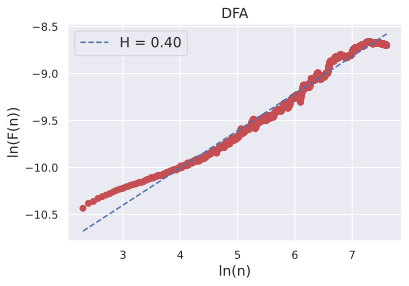

In [52]:
plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), '--', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

In [56]:
%%time
pymfdfb = fathon.MFDFA(data)
n, F = pymfdfb.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)



CPU times: user 11min 40s, sys: 701 ms, total: 11min 41s
Wall time: 1min 23s


In [58]:
list_H, list_H_intercept = pymfdfb.fitFlucVec()

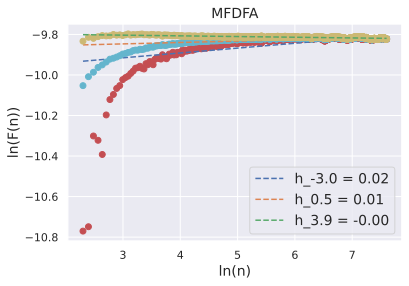

In [59]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), '--', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         '--', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), '--',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

Text(0.5, 1.0, 'h(q)')

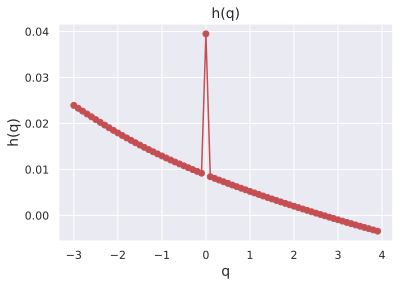

In [60]:
plt.plot(qs, list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)

In [67]:
tau = pymfdfb.computeMassExponents()


Text(0.5, 1.0, '$\\tau$(q)')

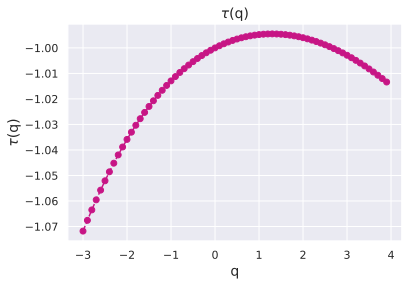

In [68]:
plt.plot(qs, tau, 'o--', color='mediumvioletred')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)

In [63]:
alpha, mfSpect = pymfdfb.computeMultifractalSpectrum()

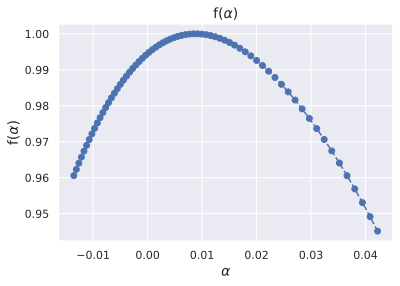

In [64]:
_=plt.plot(alpha, mfSpect, 'bo--')
_=plt.xlabel('$\\alpha$', fontsize=14)
_=plt.ylabel('f($\\alpha$)', fontsize=14)
_=plt.title('f($\\alpha$)', fontsize=14)